## SERIES DE TIEMPO PARA PRONÓSTICOS EN ECONOMÍA Y FINANZAS
### CLASE 3: Ciclos - procesos AR

<div style="text-align: right"> Elaborado por Jorge Guerra </div>
<div style="text-align: right"> @jguerrae18 </div>
<div style="text-align: right"> ja.guerrae@uniandes.edu.co </div>

In [151]:
import warnings 
warnings.filterwarnings("ignore") #código para ignorar los anuncios de alertas

> **¿Qué haremos el día de hoy?**

El análisis se basará en una sola variable. El PIB trimestral en Colombia  desde el primer trimestre de 1994 hasta el tercer trimestre de 2019.La fuente de datos es el Departamento Administrativo Nacional de Estadística de Colombia. El código se dividirá en las siguientes secciones:

1. Modelos lineales.
2. Modelos no lineales.
3. Prónosticos fuera de muestra.
4. Criterios de selección.
5. Modelo estacionales y prónostico fuera de muestra.
6. Criterios de Selección de los modelos
---


In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [153]:
df = pd.read_excel("PIB.xlsx") #leer base de datos

In [154]:
df["FECHA"] = pd.to_datetime(df["FECHA"]) #convertir en formato fecha
df = df.set_index("FECHA") #fijar la fecha como un índice ( ya no como columna)

In [155]:
df.describe()

,PIB
count,103.000000
mean,147517.254108
std,40216.600488
min,95825.134684
25%,109055.532868
50%,140812.757221
75%,184389.738658
max,221360.736396


## Exploración inicial

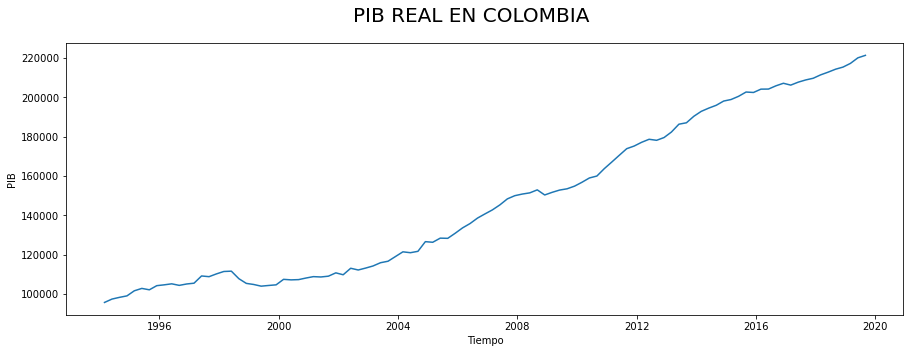

In [156]:
#Inspección inicial

fig = plt.figure( figsize=(15,5))
fig.suptitle('PIB REAL EN COLOMBIA', fontsize=20)

plt.xlabel('Tiempo', fontsize=10)
plt.ylabel('PIB', fontsize=10)
sns.lineplot(data = df, y = "PIB", x = "FECHA", dashes= True, err_style ="bars")

fig.show()

In [157]:
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf #autocorrelación, autocorr parcial

Text(0, 0.5, 'PACF')

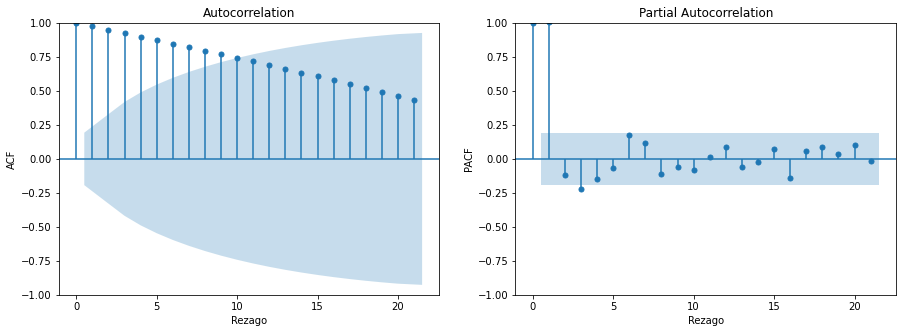

In [158]:
fig, ax =plt.subplots(1,2, figsize=(15, 5), sharex = False)

#FIG 1
plot_acf(df.PIB, ax = ax[0], alpha = 0.05)
ax[0].set_xlabel('Rezago', fontsize=10)
ax[0].set_ylabel('ACF', fontsize=10)

#FIG 2
plot_pacf(df.PIB, ax = ax[1], alpha = 0.05, method = "ols")
ax[1].set_xlabel('Rezago', fontsize=10)
ax[1].set_ylabel('PACF', fontsize=10)

## Volviendo estacionaria la serie
### Primera aproximación: tendencia exponencial

In [159]:
df["LPIB"] = np.log(df.PIB)
df["TIME"] = np.arange(1,len(df)+1)

In [160]:
import statsmodels.formula.api as sm

In [161]:
model1 = sm.ols(formula='LPIB ~ TIME', data=df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   LPIB   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     3019.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):           4.68e-77
Time:                        17:33:31   Log-Likelihood:                 166.18
No. Observations:                 103   AIC:                            -328.4
Df Residuals:                     101   BIC:                            -323.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.4046      0.010   1180.214      0.0

In [162]:
from scipy import optimize

In [163]:
Ynorm = np.array(df.LPIB)/np.max(df.LPIB)
Xnorm = np.array(df["TIME"])/np.max(df["TIME"])

# (2) Función a estimar
def func(x, a, b):
    y = a*np.exp(b*x)
    return y

# (3) Parámetros óptimos
alpha, beta = optimize.curve_fit(func, xdata = Xnorm, ydata = Ynorm)[0]
print(f'alpha={alpha}, beta={beta}')

alpha=0.9270540374293241, beta=0.07708819356111983


In [164]:
Y2_pred = func(Xnorm, alpha, beta) * np.max(df.LPIB) #volver a niveles


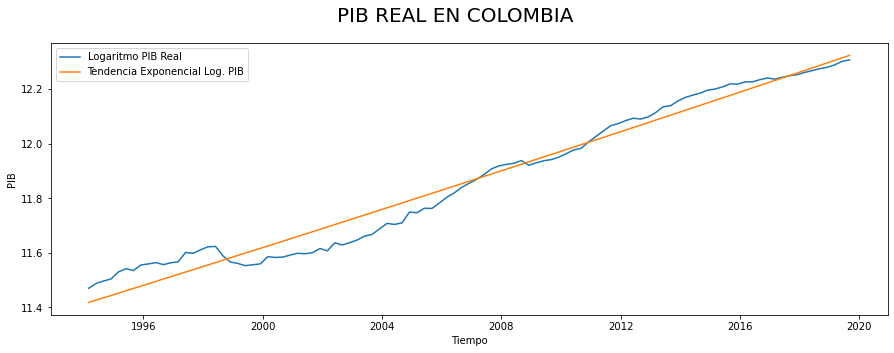

In [165]:
fig = plt.figure( figsize=(15,5))
fig.suptitle('PIB REAL EN COLOMBIA', fontsize=20)
plt.xlabel('Tiempo', fontsize=10)
plt.ylabel('PIB', fontsize=10)
sns.lineplot(data = df, y = "LPIB", x = "FECHA", dashes= True, err_style ="bars")
sns.lineplot(y = Y2_pred, x = df.index, dashes= True, err_style ="bars")
plt.legend(["Logaritmo PIB Real", "Tendencia Exponencial Log. PIB"])

In [166]:
##BRECHA
df["brecha"] = (df.LPIB-Y2_pred)*100

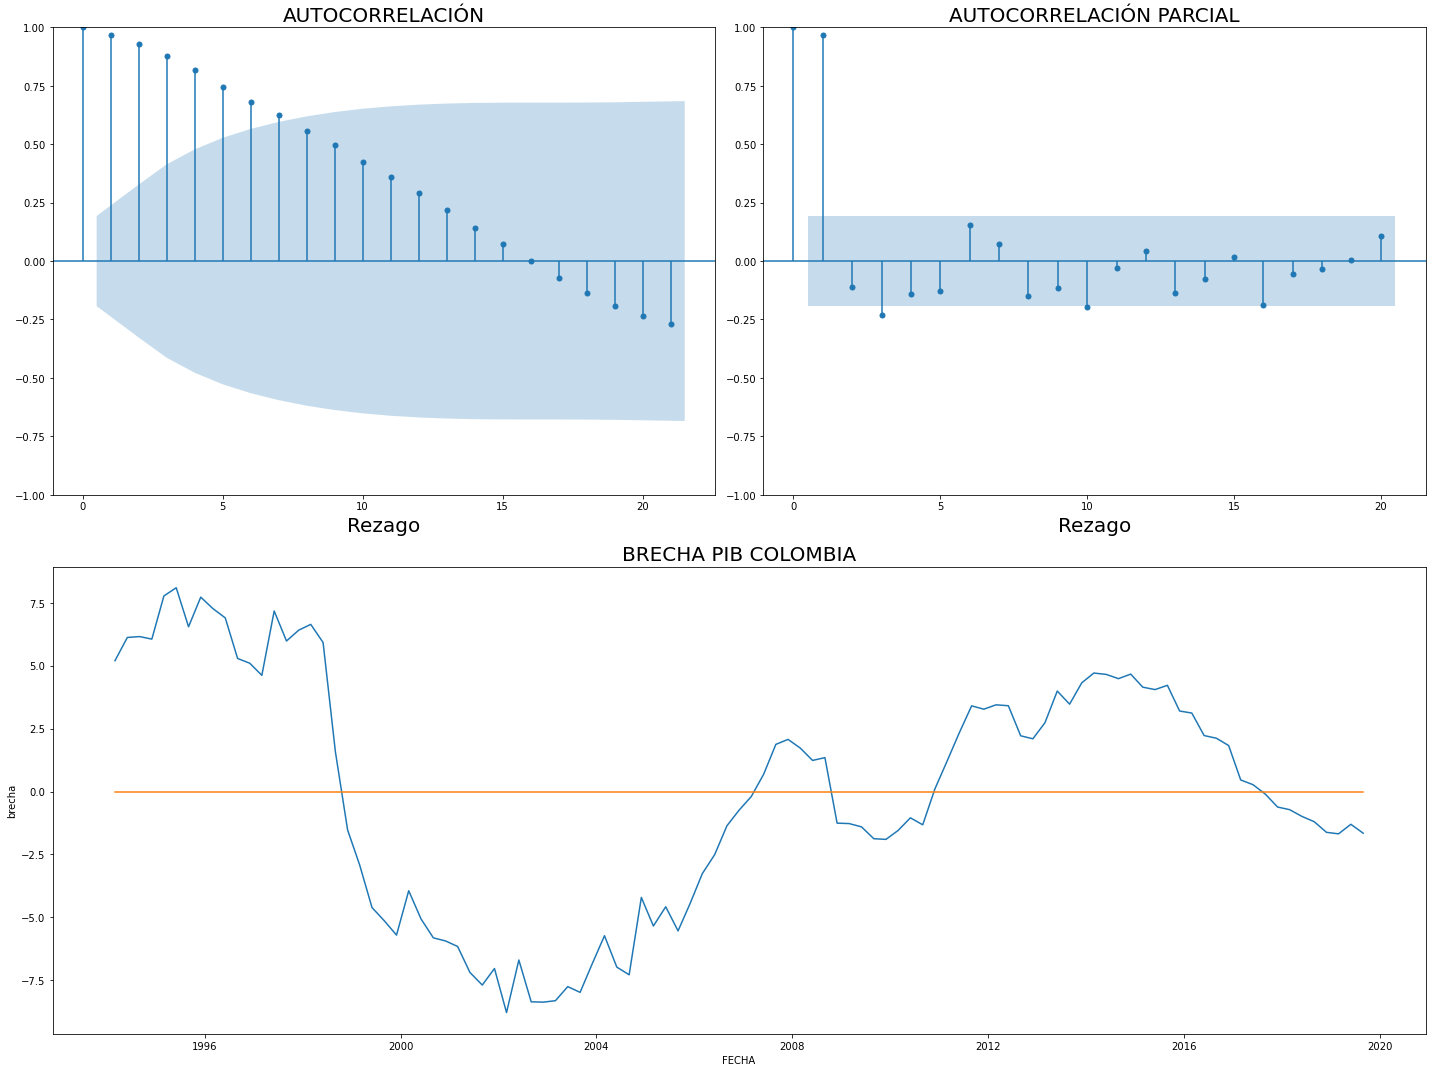

In [167]:
fig = plt.figure(figsize=(20, 15))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)


plot_acf(df.brecha, ax = ax1, alpha = 0.05)
ax1.set_xlabel('Rezago', fontsize=20)
ax1.set_title(r"AUTOCORRELACIÓN", fontsize=20)


plot_pacf(df.brecha, ax = ax2, lags  = 20, alpha = 0.05, method = "ols")
ax2.set_xlabel('Rezago', fontsize=20)
ax2.set_title(r"AUTOCORRELACIÓN PARCIAL", fontsize=20)

sns.lineplot(data = df, y = "brecha", x = "FECHA", dashes= True, err_style ="bars", ax = ax3)
sns.lineplot(y = np.zeros(len(df)),  x = df.index, dashes= True, err_style ="bars", ax = ax3)
ax3.set_title(r"BRECHA PIB COLOMBIA", fontsize=20)



plt.tight_layout()
plt.show()

Fuente: https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html

In [168]:
##BRECHA AR1
from statsmodels.tsa.arima.model import ARIMA

AR1 = ARIMA(df["brecha"], order=(1, 0, 0)).fit()
print(AR1.summary())

                               SARIMAX Results                                
Dep. Variable:                 brecha   No. Observations:                  103
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -154.239
Date:                Tue, 18 Jan 2022   AIC                            314.477
Time:                        17:33:33   BIC                            322.381
Sample:                    03-01-1994   HQIC                           317.678
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7017      2.964      0.237      0.813      -5.107       6.511
ar.L1          0.9712      0.022     44.567      0.000       0.929       1.014
sigma2         1.1379      0.121      9.400      0.0

In [169]:
#ESTIMACIÓN DENTRO DE MUESTRA
df["fit1"] = df.brecha - AR1.resid
df["fit1"] = AR1.fittedvalues

In [170]:
##ESTIMACIÓN FUERA DE MUESTRA

In [171]:
AR1F = ARIMA(df["brecha"][0:84], order=(1, 0, 0)).fit()
print(AR1F.summary())

                               SARIMAX Results                                
Dep. Variable:                 brecha   No. Observations:                   84
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -132.777
Date:                Tue, 18 Jan 2022   AIC                            271.554
Time:                        17:33:33   BIC                            278.846
Sample:                    03-01-1994   HQIC                           274.485
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1367      4.929      0.433      0.665      -7.525      11.798
ar.L1          0.9722      0.026     37.098      0.000       0.921       1.024
sigma2         1.3350      0.176      7.592      0.0

In [172]:
AR1Fp= AR1F.forecast(19)

In [173]:
UpCF1 = AR1F.get_forecast(steps = 19).conf_int()["upper brecha"]
LoCF1 = AR1F.get_forecast(steps = 19).conf_int()["lower brecha"]

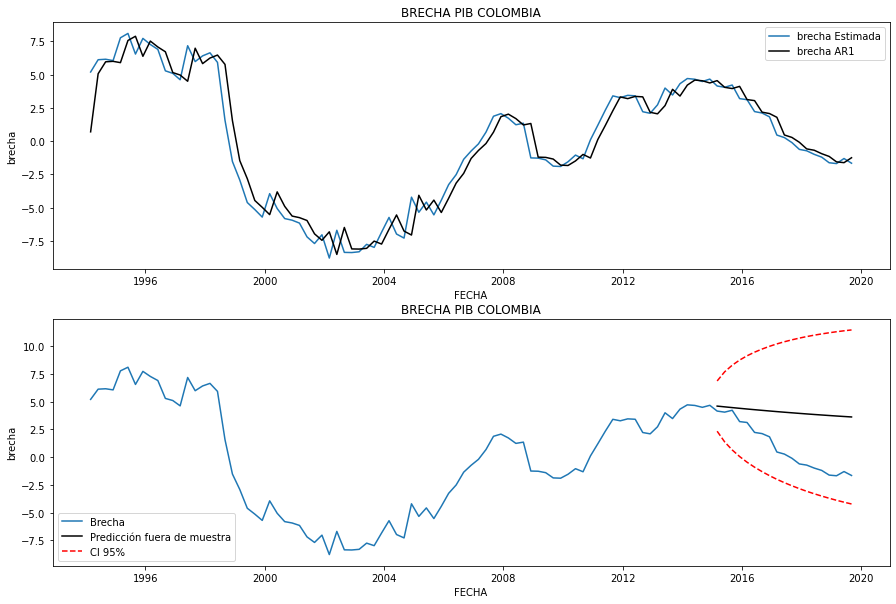

In [174]:
fig, ax =plt.subplots(2,1, figsize=(15, 10), sharex = False)

#FIG 0,0
sns.lineplot(x=df.index, y=df.brecha, ax = ax[0])
sns.lineplot(x=df.index, y=df["fit1"], color = "black", ax = ax[0])

ax[0].legend(labels=['brecha Estimada', 'brecha AR1'], prop={'size': 10})
ax[0].set_title(r"BRECHA PIB COLOMBIA", fontsize=12)

# #FIG 0,0
sns.lineplot(x=df.index, y=df.brecha, ax = ax[1])
sns.lineplot(x=AR1Fp.index, y=AR1Fp, ax = ax[1], color = "black")
sns.lineplot(x=AR1Fp.index, y=UpCF1, ax = ax[1], color = "r", linestyle='--')
sns.lineplot(x=AR1Fp.index, y=LoCF1, ax = ax[1], color='r', linestyle='--')

ax[1].legend(labels=['Brecha', 'Predicción fuera de muestra', "CI 95%"], prop={'size': 10})
ax[1].set_title(r"BRECHA PIB COLOMBIA", fontsize=12)

fig.show()

Text(0, 0.5, 'PACF')

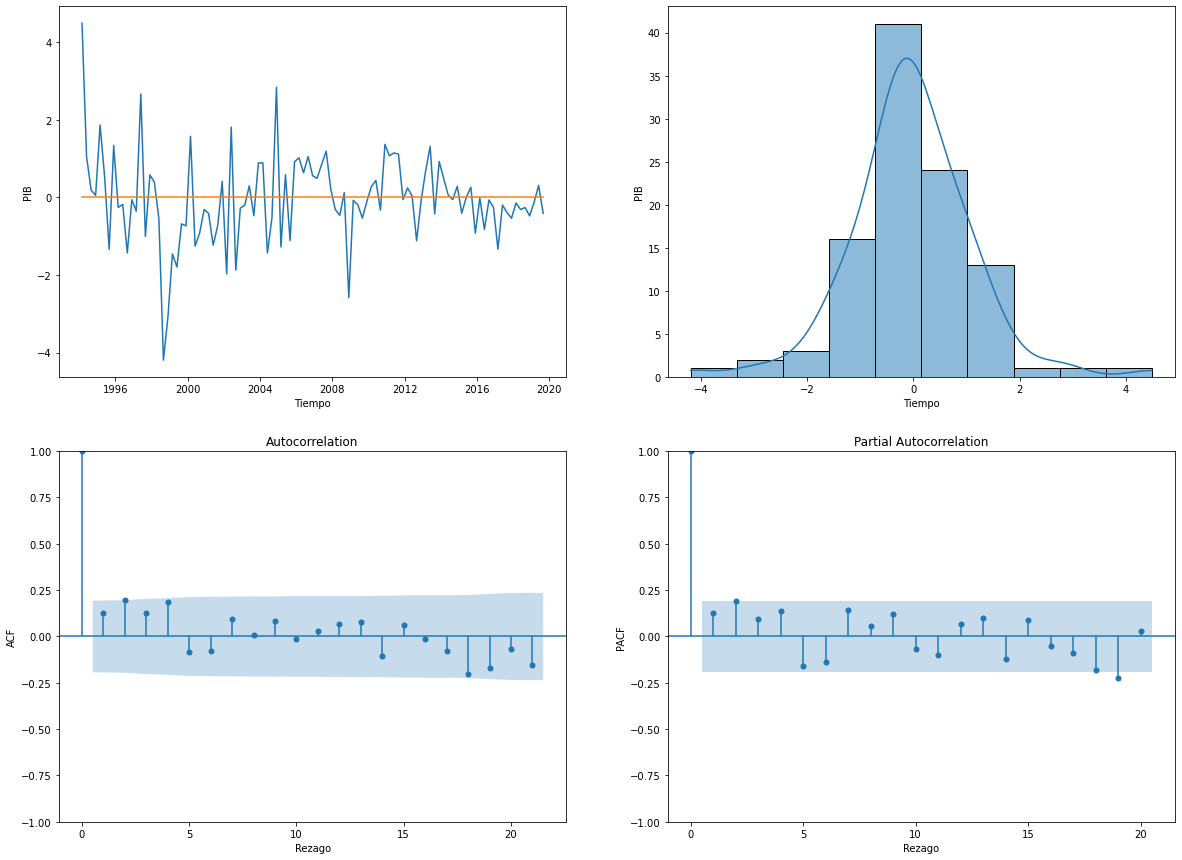

In [175]:
fig, ax =plt.subplots(2,2, figsize=(20, 15), sharex = False)

#FIG 0,0
sns.lineplot(y = AR1.resid, x = AR1.resid.index, dashes= True, err_style ="bars", ax = ax[0, 0])
sns.lineplot(y = np.zeros(len(AR1.resid)),  x = AR1.resid.index, dashes= True, err_style ="bars", ax = ax[0, 0])
ax[0,0].set_xlabel('Tiempo', fontsize=10)
ax[0,0].set_ylabel('PIB', fontsize=10)


sns.histplot(x = AR1.resid , ax=ax[0,1], bins = 10, kde = True)
ax[0,1].set_xlabel('Tiempo', fontsize=10)
ax[0,1].set_ylabel('PIB', fontsize=10)


#FIG 1
plot_acf(AR1.resid, ax = ax[1,0], alpha = 0.05)
ax[1,0].set_xlabel('Rezago', fontsize=10)
ax[1,0].set_ylabel('ACF', fontsize=10)

#FIG 2
plot_pacf(AR1.resid, ax = ax[1,1], lags  = 20, alpha = 0.05, method = "ols")
ax[1,1].set_xlabel('Rezago', fontsize=10)
ax[1,1].set_ylabel('PACF', fontsize=10)


In [176]:
import statsmodels.api as sm

A = pd.DataFrame()
for i in range(5,16,5):
    B  = sm.stats.acorr_ljungbox(AR1.resid, lags=[i], return_df=True)
    A = pd.concat([A,B])

A

,lb_stat,lb_pvalue
5,12.288424,0.031042
10,14.789680,0.139920
15,18.018619,0.261688


## Variación del PIB

In [177]:
df["CPIB"] = df["PIB"].pct_change(4)*100

Text(0, 0.5, 'PACF')

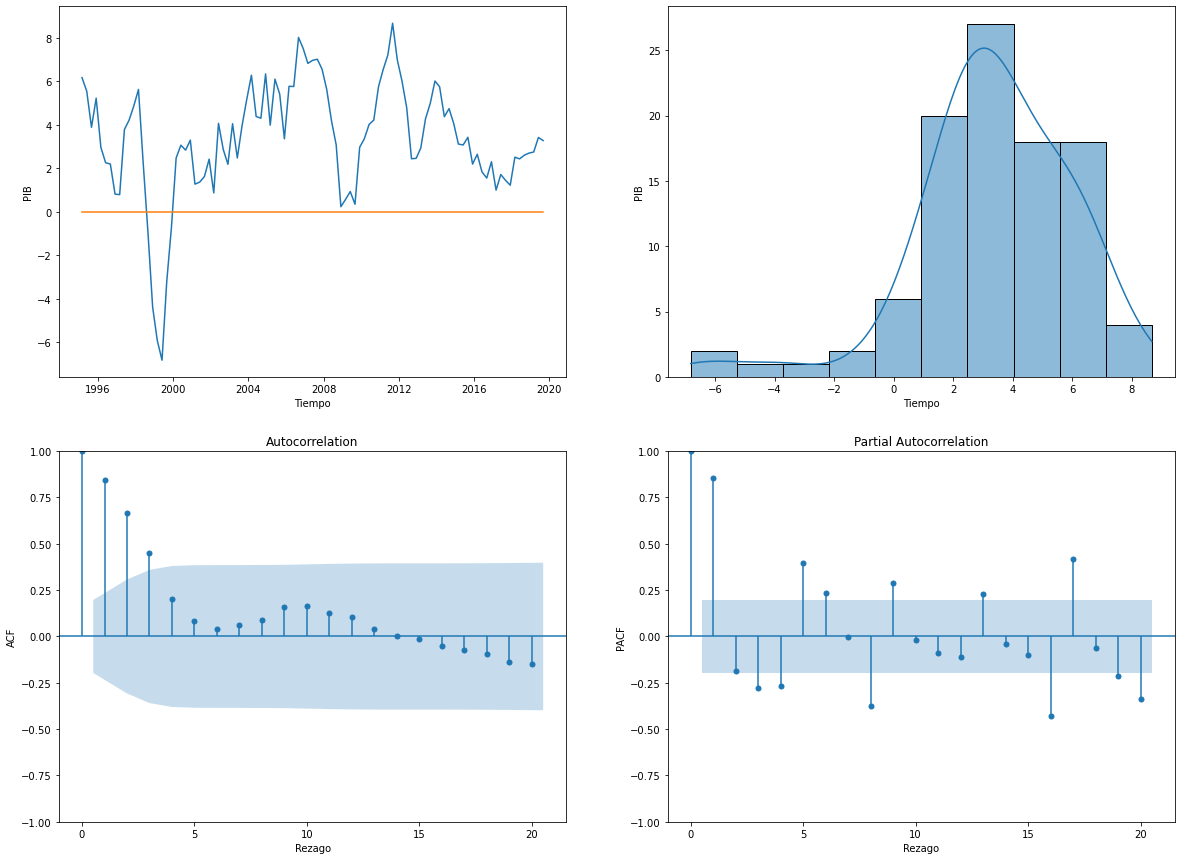

In [178]:
fig, ax =plt.subplots(2,2, figsize=(20, 15), sharex = False)

#FIG 0,0
sns.lineplot(y = df["CPIB"].dropna(), x = df["CPIB"].dropna().index, dashes= True, err_style ="bars", ax = ax[0, 0])
sns.lineplot(y = np.zeros(len(df["CPIB"].dropna())),  x = df["CPIB"].dropna().index, dashes= True, err_style ="bars", ax = ax[0, 0])
ax[0,0].set_xlabel('Tiempo', fontsize=10)
ax[0,0].set_ylabel('PIB', fontsize=10)


sns.histplot(x = df["CPIB"].dropna() , ax=ax[0,1], bins = 10, kde = True)
ax[0,1].set_xlabel('Tiempo', fontsize=10)
ax[0,1].set_ylabel('PIB', fontsize=10)


#FIG 1
plot_acf(df["CPIB"].dropna(), ax = ax[1,0], alpha = 0.05)
ax[1,0].set_xlabel('Rezago', fontsize=10)
ax[1,0].set_ylabel('ACF', fontsize=10)

#FIG 2
plot_pacf(df["CPIB"].dropna(), ax = ax[1,1], lags  = 20, alpha = 0.05)
ax[1,1].set_xlabel('Rezago', fontsize=10)
ax[1,1].set_ylabel('PACF', fontsize=10)

In [179]:
AR5 = ARIMA(df["CPIB"].dropna(), order=(5, 0, 0)).fit()
print(AR5.summary())

                               SARIMAX Results                                
Dep. Variable:                   CPIB   No. Observations:                   99
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -159.458
Date:                Tue, 18 Jan 2022   AIC                            332.915
Time:                        17:33:36   BIC                            351.081
Sample:                    03-01-1995   HQIC                           340.265
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4106      0.660      5.171      0.000       2.118       4.703
ar.L1          0.9631      0.081     11.818      0.000       0.803       1.123
ar.L2          0.1469      0.126      1.165      0.2

In [180]:
#ESTIMACIÓN DENTRO DE MUESTRA
df["fit2"] = df.CPIB - AR5.resid
df["fit2"] = AR5.fittedvalues

In [181]:
##ESTIMACIÓN FUERA DE MUESTRA

In [182]:
AR5F = ARIMA(df["CPIB"][0:84].dropna(), order=(5, 0, 0)).fit()
print(AR5F.summary())

                               SARIMAX Results                                
Dep. Variable:                   CPIB   No. Observations:                   80
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -135.727
Date:                Tue, 18 Jan 2022   AIC                            285.454
Time:                        17:33:36   BIC                            302.128
Sample:                    03-01-1995   HQIC                           292.139
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6738      0.802      4.579      0.000       2.101       5.246
ar.L1          0.9697      0.096     10.068      0.000       0.781       1.159
ar.L2          0.1368      0.150      0.913      0.3

In [183]:
AR5Fp= AR5F.forecast(19)

In [184]:
UpCF5 = AR5F.get_forecast(steps = 19).conf_int()["upper CPIB"]
LoCF5 = AR5F.get_forecast(steps = 19).conf_int()["lower CPIB"]

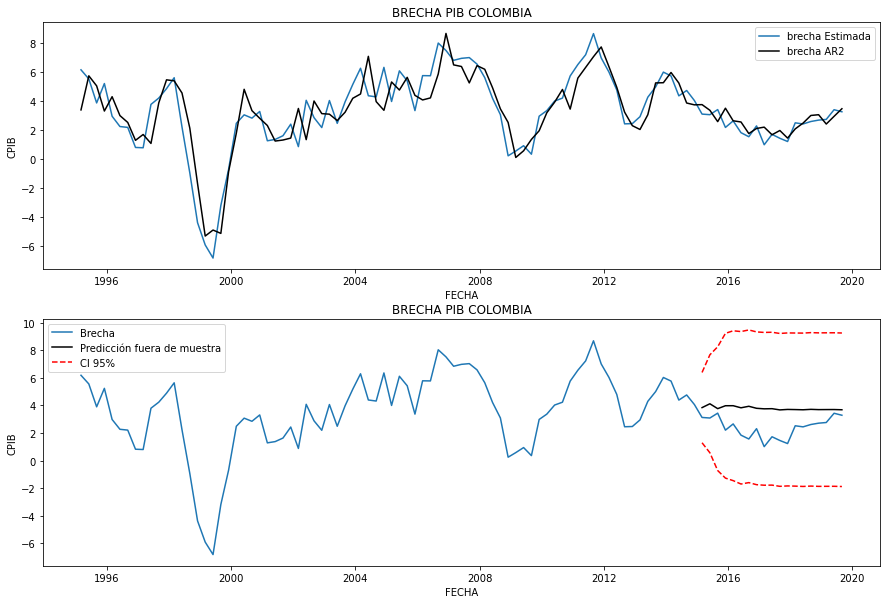

In [185]:
fig, ax =plt.subplots(2,1, figsize=(15, 10), sharex = False)

#FIG 0,0
sns.lineplot(x=df["CPIB"].dropna().index, y=df["CPIB"].dropna(), ax = ax[0])
sns.lineplot(x=df["CPIB"].dropna().index, y=df["fit2"].dropna(), color = "black", ax = ax[0])

ax[0].legend(labels=['brecha Estimada', 'brecha AR2'], prop={'size': 10})
ax[0].set_title(r"BRECHA PIB COLOMBIA", fontsize=12)

# #FIG 0,0
sns.lineplot(x=df["CPIB"].dropna().index, y=df["CPIB"].dropna(), ax = ax[1])
sns.lineplot(x=AR5Fp.index, y=AR5Fp, ax = ax[1], color = "black")
sns.lineplot(x=AR5Fp.index, y=UpCF5, ax = ax[1], color = "r", linestyle='--')
sns.lineplot(x=AR5Fp.index, y=LoCF5, ax = ax[1], color='r', linestyle='--')

ax[1].legend(labels=['Brecha', 'Predicción fuera de muestra', "CI 95%"], prop={'size': 10})
ax[1].set_title(r"BRECHA PIB COLOMBIA", fontsize=12)

fig.show()

Text(0, 0.5, 'PACF')

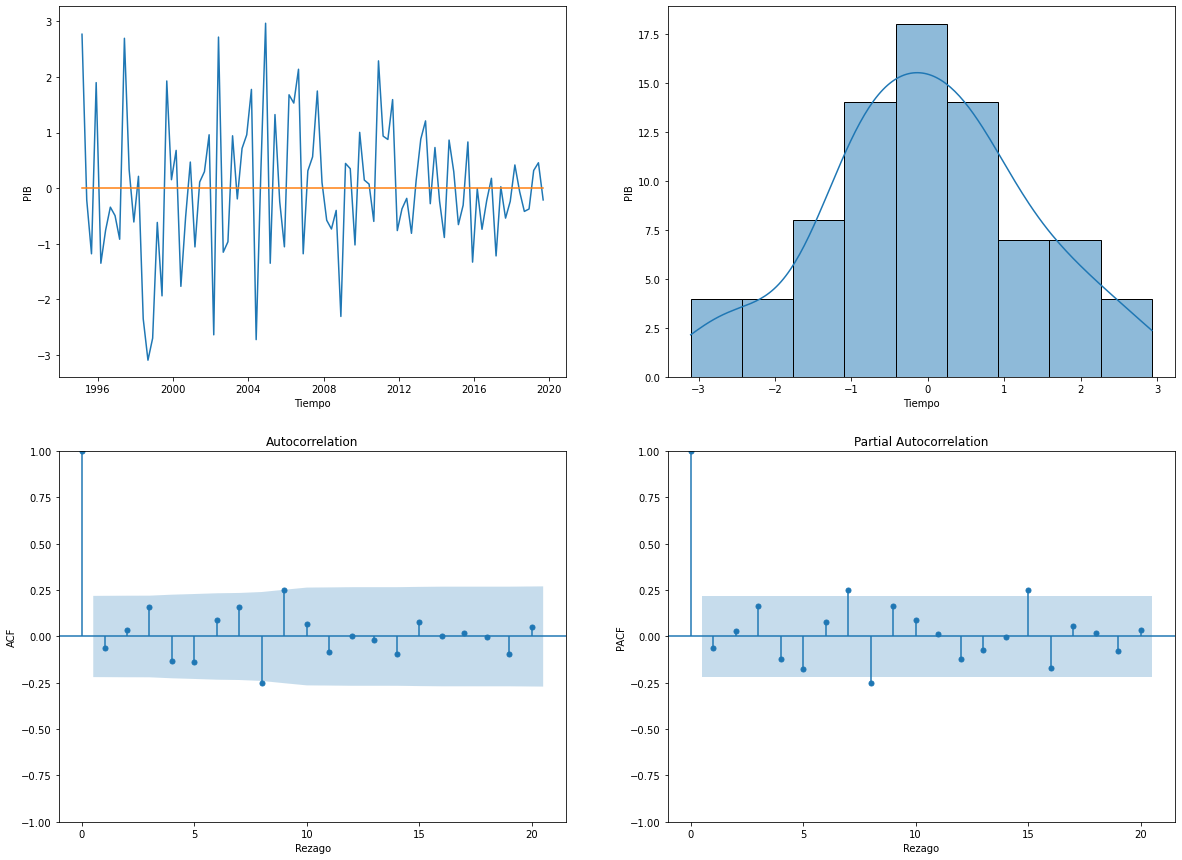

In [186]:
fig, ax =plt.subplots(2,2, figsize=(20, 15), sharex = False)

#FIG 0,0
sns.lineplot(y = AR5.resid, x = AR5.resid.index, dashes= True, err_style ="bars", ax = ax[0, 0])
sns.lineplot(y = np.zeros(len(AR5.resid)),  x = AR5.resid.index, dashes= True, err_style ="bars", ax = ax[0, 0])
ax[0,0].set_xlabel('Tiempo', fontsize=10)
ax[0,0].set_ylabel('PIB', fontsize=10)


sns.histplot(x = AR5F.resid , ax=ax[0,1], bins = 9, kde = True)
ax[0,1].set_xlabel('Tiempo', fontsize=10)
ax[0,1].set_ylabel('PIB', fontsize=10)


#FIG 1
plot_acf(AR5F.resid, ax = ax[1,0], alpha = 0.05)
ax[1,0].set_xlabel('Rezago', fontsize=10)
ax[1,0].set_ylabel('ACF', fontsize=10)

#FIG 2
plot_pacf(AR5F.resid, ax = ax[1,1], lags  = 20, alpha = 0.05, method = "ols")
ax[1,1].set_xlabel('Rezago', fontsize=10)
ax[1,1].set_ylabel('PACF', fontsize=10)


In [187]:
import statsmodels.api as sm

A = pd.DataFrame()
for i in range(5,16,5):
    B  = sm.stats.acorr_ljungbox(AR5.resid, lags=[i], return_df=True)
    A = pd.concat([A,B])

A

,lb_stat,lb_pvalue
5,6.448629,0.264978
10,23.510785,0.009010
15,25.639131,0.041991
